In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
from pandas import read_csv
er = pd.read_csv("USDCNY(2011-2021).csv", header=0)
er.head(5)

,slug,date,open,high,low,close,currency
0,USD/CNY,2011/1/3,6.5800,6.5800,6.5800,6.5916,CNY
1,USD/CNY,2011/1/4,6.5988,6.6000,6.5970,6.5800,CNY
2,USD/CNY,2011/1/5,6.6112,6.6112,6.5775,6.5970,CNY
3,USD/CNY,2011/1/6,6.6134,6.6165,6.6134,6.5775,CNY
4,USD/CNY,2011/1/7,6.6209,6.6209,6.6175,6.6165,CNY


In [3]:
er.date = pd.to_datetime(er.date)
er.set_index("date", inplace=True)

In [4]:
er.head()

,slug,open,high,low,close,currency
date,,,,,,
2011-01-03,USD/CNY,6.5800,6.5800,6.5800,6.5916,CNY
2011-01-04,USD/CNY,6.5988,6.6000,6.5970,6.5800,CNY
2011-01-05,USD/CNY,6.6112,6.6112,6.5775,6.5970,CNY
2011-01-06,USD/CNY,6.6134,6.6165,6.6134,6.5775,CNY
2011-01-07,USD/CNY,6.6209,6.6209,6.6175,6.6165,CNY


In [5]:
er.tail()

,slug,open,high,low,close,currency
date,,,,,,
2021-08-24,USD/CNY,6.4800,6.4832,6.4686,6.4800,CNY
2021-08-25,USD/CNY,6.4699,6.4783,6.4675,6.4699,CNY
2021-08-26,USD/CNY,6.4749,6.4856,6.4725,6.4749,CNY
2021-08-27,USD/CNY,6.4805,6.4867,6.4694,6.4805,CNY
2021-08-30,USD/CNY,6.4711,6.4717,6.4620,6.4658,CNY


In [6]:
er_price = er[['close']]

In [7]:
valid_start = '2019-8-1'
test_start =  '2020-8-3'

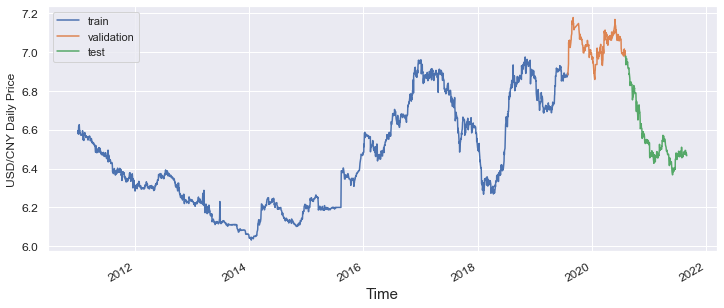

In [8]:
er_price[: valid_start][['close']].rename(columns={'close':'train'}) \
    .join(er_price[valid_start: test_start][['close']] \
          .rename(columns={'close':'validation'}), how='outer') \
    .join(er_price[test_start:][['close']].rename(columns={'close':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(12, 5), fontsize=12)
plt.xlabel('Time', fontsize=15)
plt.ylabel('USD/CNY Daily Price', fontsize=12)
plt.show()

# SVR model when K=1

In [9]:
K = 1
HORIZON = 1

In [10]:
train_er = er_price[:valid_start].copy()

               close
date                
2011-01-03  0.593959
2011-01-04  0.581664
2019-07-31  0.903445
2019-08-01  0.903233


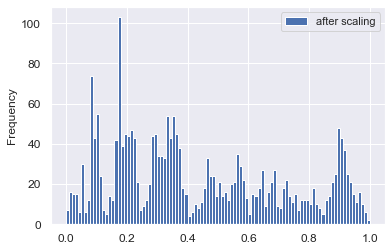

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_er['close'] = scaler.fit_transform(train_er)
print(train_er.head(2).append(train_er.tail(2)))
train_er.rename(columns={'close':'after scaling'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [12]:
train_shifted = train_er
train_shifted['close_t+1'] = train_er['close'].shift(-1)
train_shifted.head(2)

,close,close_t+1
date,,
2011-01-03,0.593959,0.581664
2011-01-04,0.581664,0.599682


In [13]:
for t in range(K):
    train_shifted['close_t-{}'.format(t)] = train_shifted['close'].shift(t)
train_shifted.head()

,close,close_t+1,close_t-0
date,,,
2011-01-03,0.593959,0.581664,0.593959
2011-01-04,0.581664,0.599682,0.581664
2011-01-05,0.599682,0.579014,0.599682
2011-01-06,0.579014,0.620350,0.579014
2011-01-07,0.620350,0.621410,0.620350


In [14]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head()

,close,close_t+1,close_t-0
date,,,
2011-01-03,0.593959,0.581664,0.593959
2011-01-04,0.581664,0.599682,0.581664
2011-01-05,0.599682,0.579014,0.599682
2011-01-06,0.579014,0.620350,0.579014
2011-01-07,0.620350,0.621410,0.620350


In [15]:
y_data = ['close_t+1']
X_data = ['close_t-{}'.format(idx) for idx in range(0, K)]

In [16]:
y_train = train_shifted[y_data].values
print(y_train.shape)
X_train = train_shifted[X_data].values
print(X_train.shape)

(2233, 1)
(2233, 1)


In [17]:
from sklearn.svm import SVR

from sklearn.metrics import r2_score

In [18]:
svr0 = SVR(kernel='rbf',gamma=0.005, C=100,epsilon=0.01)
svr0.fit(X_train, y_train)

/Users/yanzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100, epsilon=0.01, gamma=0.005)

In [19]:
index_pre = er_price.index.get_loc(valid_start) - K
true_valid_start = er_price.index[index_pre]

In [20]:
val_df = er_price[true_valid_start:test_start].copy()
val_df['close'] = scaler.transform(val_df)
print(val_df.head(2).append(val_df.tail(2)))

               close
date                
2019-07-31  0.903445
2019-08-01  0.903233
2020-07-31  1.034552
2020-08-03  0.999470


In [21]:
valid_shifted = val_df.copy()
valid_shifted['close_t+1'] = val_df['close'].shift(-1)
for t in range(K):
     valid_shifted['close_t-{}'.format(t)] = valid_shifted['close'].shift(t)
valid_shifted = valid_shifted.dropna(how='any')
y_valid = valid_shifted[y_data].values
X_valid = valid_shifted[X_data].values

In [22]:
predictions = svr0.predict(X_valid)
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = valid_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction1', var_name='h')
eval_df['actual'] = np.transpose(y_valid).ravel()
eval_df[['prediction1', 'actual']] = scaler.inverse_transform(eval_df[['prediction1', 'actual']])
eval_df.head()

,timestamp,h,prediction1,actual
0,2019-07-31,t+1,6.883211,6.8834
1,2019-08-01,t+1,6.883011,6.8978
2,2019-08-02,t+1,6.897368,6.9392
3,2019-08-05,t+1,6.938627,7.0497
4,2019-08-06,t+1,7.048625,7.0256


In [23]:
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [24]:
svr0_pred = svr0.predict(X_valid)
print('Valid MAE:',mean_absolute_error(y_valid, svr0_pred))
print('Valid MSE:',mean_squared_error(y_valid, svr0_pred))
print("Valid R2:",r2_score(y_valid, svr0_pred))
mape_test = np.mean(np.abs((eval_df['prediction1'] - eval_df['actual']) / eval_df['actual'])) * 100
print('Valid MAPE is {:.2f}%'.format(mape_test))

Valid MAE: 0.014311757938500338
Valid MSE: 0.00043606425802136117
Valid R2: 0.9019800627647736
Valid MAPE is 0.19%


In [25]:
index_pre = er_price.index.get_loc(test_start) - K

In [26]:
true_valid_start = er_price.index[index_pre]
test_df = er_price[true_valid_start:].copy()
test_df['close'] = scaler.transform(test_df)
print(test_df.head(2).append(test_df.tail(2)))

               close
date                
2020-07-31  1.034552
2020-08-03  0.999470
2021-08-27  0.476206
2021-08-30  0.460625


In [27]:
test_shifted = test_df.copy()
test_shifted['close_t+1'] = test_shifted['close'].shift(-1)
for t in range(0, K):
     test_shifted['close_t-{}'.format(t)] = test_shifted['close'].shift(t)
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted[y_data].values
X_test = test_shifted[X_data].values

In [28]:
predictions = svr0.predict(X_test)

In [29]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['date'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='date', value_name='prediction1', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction1', 'actual']] = scaler.inverse_transform(eval_df[['prediction1', 'actual']])
eval_df.head()

,date,h,prediction1,actual
0,2020-07-31,t+1,7.006441,6.9742
1,2020-08-03,t+1,6.973489,6.9794
2,2020-08-04,t+1,6.978667,6.9727
3,2020-08-05,t+1,6.971995,6.9346
4,2020-08-06,t+1,6.934044,6.9524


In [30]:
svr0_pred = svr0.predict(X_test)
print('Test MAE:',mean_absolute_error(y_test, svr0_pred))
print('Test MSE:',mean_squared_error(y_test, svr0_pred))
print("Test R2:",r2_score(y_test, svr0_pred))
mape_test = np.mean(np.abs((eval_df['prediction1'] - eval_df['actual']) / eval_df['actual'])) * 100
print('Test MAPE is {:.2f}%'.format(mape_test))

Test MAE: 0.012036739139647057
Test MSE: 0.00029711770423616744
Test R2: 0.989004263474302
Test MAPE is 0.17%


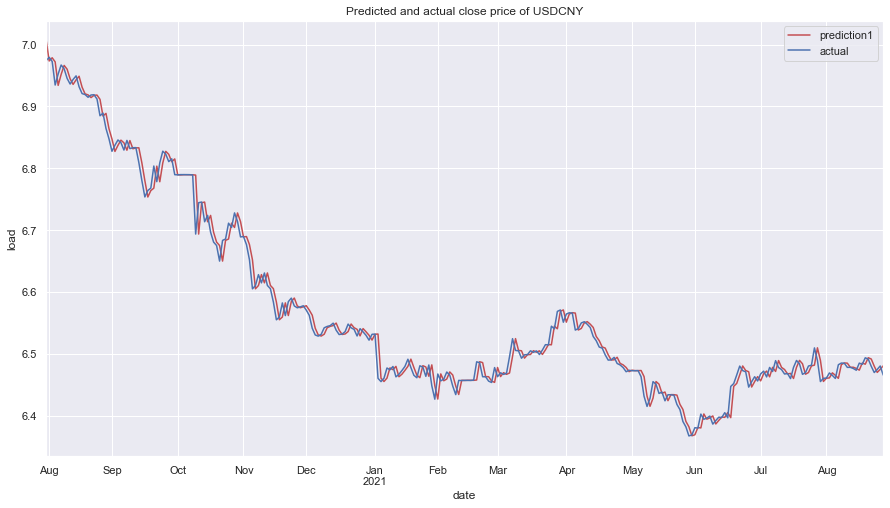

In [31]:
eval_df.plot(x='date', y=['prediction1', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.title('Predicted and actual close price of USDCNY')
plt.xlabel('date', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

# Random Forest model when K=1

In [32]:
from sklearn.ensemble import RandomForestRegressor

In [33]:
index_pre = er_price.index.get_loc(test_start) - K
true_valid_start = er_price.index[index_pre]
test_df = er_price[true_valid_start:].copy()
test_df['close'] = scaler.transform(test_df)
print(test_df.head(2).append(test_df.tail(2)))

               close
date                
2020-07-31  1.034552
2020-08-03  0.999470
2021-08-27  0.476206
2021-08-30  0.460625


In [34]:
#Random Forest
rfg = RandomForestRegressor()
rfg.fit(X_train, y_train)
rfg_pred = rfg.predict(X_test)

/var/folders/v3/450qq1rj1dg9h7f9glq8l6wh0000gn/T/ipykernel_65888/464134978.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfg.fit(X_train, y_train)


In [35]:
test_shifted = test_df.copy()
test_shifted['close_t+1'] = test_shifted['close'].shift(-1)
for t in range(0, K):
     test_shifted['close_t-{}'.format(t)] = test_shifted['close'].shift(t)
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted[y_data].values
X_test = test_shifted[X_data].values

In [36]:
predictions = rfg.predict(X_test)

In [37]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['date'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='date', value_name='prediction1', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction1', 'actual']] = scaler.inverse_transform(eval_df[['prediction1', 'actual']])
eval_df.head()

,date,h,prediction1,actual
0,2020-07-31,t+1,6.935459,6.9742
1,2020-08-03,t+1,6.935459,6.9794
2,2020-08-04,t+1,6.935459,6.9727
3,2020-08-05,t+1,6.935459,6.9346
4,2020-08-06,t+1,6.931674,6.9524


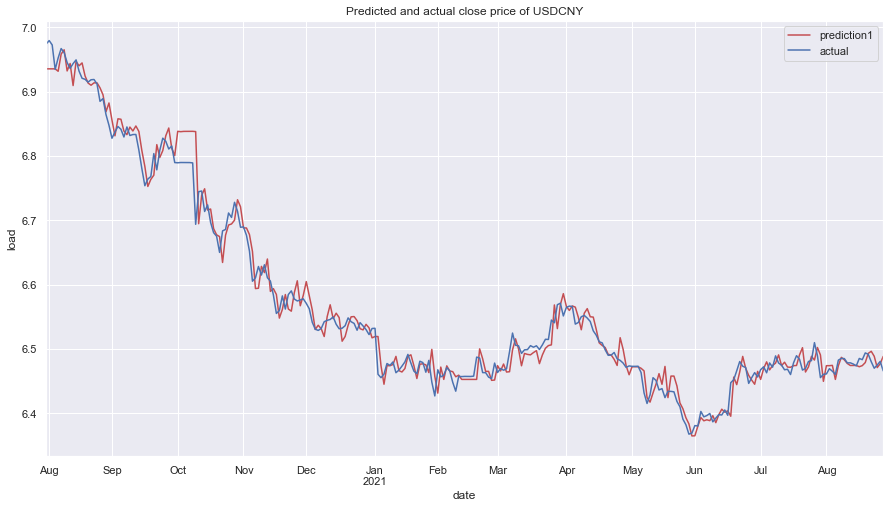

In [38]:
eval_df.plot(x='date', y=['prediction1', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.title('Predicted and actual close price of USDCNY')
plt.xlabel('date', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [39]:
print('Test MAE:',mean_absolute_error(y_test, rfg_pred))
print('Test MSE:',mean_squared_error(y_test, rfg_pred))
print("Test R2:",r2_score(y_test,rfg_pred))
mape_test = np.mean(np.abs((eval_df['prediction1'] - eval_df['actual']) / eval_df['actual'])) * 100
print('Testing MAPE is {:.2f}%'.format(mape_test))

Test MAE: 0.01616287568163218
Test MSE: 0.000505102359475637
Test R2: 0.9813071641840372
Testing MAPE is 0.23%


# SVR model when K=3

In [40]:
K = 3
HORIZON = 1

In [41]:
train_er = er_price[:valid_start].copy()

               close
date                
2011-01-03  0.593959
2011-01-04  0.581664
2019-07-31  0.903445
2019-08-01  0.903233


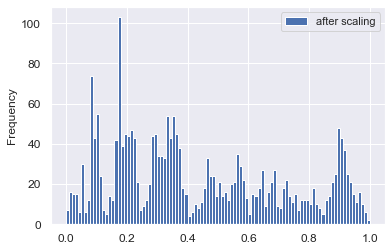

In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_er['close'] = scaler.fit_transform(train_er)
print(train_er.head(2).append(train_er.tail(2)))
train_er.rename(columns={'close':'after scaling'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [43]:
train_shifted = train_er
train_shifted['close_t+1'] = train_er['close'].shift(-1)
train_shifted.head(2)

,close,close_t+1
date,,
2011-01-03,0.593959,0.581664
2011-01-04,0.581664,0.599682


In [44]:
for t in range(K):
    train_shifted['close_t-{}'.format(t)] = train_shifted['close'].shift(t)
train_shifted.head()

,close,close_t+1,close_t-0,close_t-1,close_t-2
date,,,,,
2011-01-03,0.593959,0.581664,0.593959,NaN,NaN
2011-01-04,0.581664,0.599682,0.581664,0.593959,NaN
2011-01-05,0.599682,0.579014,0.599682,0.581664,0.593959
2011-01-06,0.579014,0.620350,0.579014,0.599682,0.581664
2011-01-07,0.620350,0.621410,0.620350,0.579014,0.599682


In [45]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head()

,close,close_t+1,close_t-0,close_t-1,close_t-2
date,,,,,
2011-01-05,0.599682,0.579014,0.599682,0.581664,0.593959
2011-01-06,0.579014,0.620350,0.579014,0.599682,0.581664
2011-01-07,0.620350,0.621410,0.620350,0.579014,0.599682
2011-01-10,0.621410,0.630419,0.621410,0.620350,0.579014
2011-01-11,0.630419,0.613461,0.630419,0.621410,0.620350


In [46]:
y_data = ['close_t+1']
X_data = ['close_t-{}'.format(idx) for idx in range(0, K)]

In [47]:
y_train = train_shifted[y_data].values
print(y_train.shape)
X_train = train_shifted[X_data].values
print(X_train.shape)

(2231, 1)
(2231, 3)


In [48]:
from sklearn.svm import SVR

from sklearn.metrics import r2_score

In [49]:
svr0 = SVR(kernel='rbf',gamma=0.005, C=100,epsilon=0.01)
svr0.fit(X_train, y_train)

/Users/yanzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100, epsilon=0.01, gamma=0.005)

In [50]:
index_pre = er_price.index.get_loc(valid_start) - K
true_valid_start = er_price.index[index_pre]

In [51]:
val_df = er_price[true_valid_start:test_start].copy()
val_df['close'] = scaler.transform(val_df)
print(val_df.head(2).append(val_df.tail(2)))

               close
date                
2019-07-29  0.897721
2019-07-30  0.912772
2020-07-31  1.034552
2020-08-03  0.999470


In [52]:
valid_shifted = val_df.copy()
valid_shifted['close_t+1'] = val_df['close'].shift(-1)
for t in range(K):
     valid_shifted['close_t-{}'.format(t)] = valid_shifted['close'].shift(t)
valid_shifted = valid_shifted.dropna(how='any')
y_valid = valid_shifted[y_data].values
X_valid = valid_shifted[X_data].values

In [53]:
predictions = svr0.predict(X_valid)
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = valid_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction3', var_name='h')
eval_df['actual'] = np.transpose(y_valid).ravel()
eval_df[['prediction3', 'actual']] = scaler.inverse_transform(eval_df[['prediction3', 'actual']])
eval_df.head()

,timestamp,h,prediction3,actual
0,2019-07-31,t+1,6.884418,6.8834
1,2019-08-01,t+1,6.884103,6.8978
2,2019-08-02,t+1,6.895335,6.9392
3,2019-08-05,t+1,6.930861,7.0497
4,2019-08-06,t+1,7.026773,7.0256


In [54]:
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [55]:
svr0_pred = svr0.predict(X_valid)
print('Valid MAE:',mean_absolute_error(y_valid, svr0_pred))
print('Valid MSE:',mean_squared_error(y_valid, svr0_pred))
print("Valid R2:",r2_score(y_valid, svr0_pred))
mape_test = np.mean(np.abs((eval_df['prediction3'] - eval_df['actual']) / eval_df['actual'])) * 100
print('Valid MAPE is {:.2f}%'.format(mape_test))

Valid MAE: 0.014092858792982435
Valid MSE: 0.00044290876916060174
Valid R2: 0.9004415313673177
Valid MAPE is 0.19%


In [56]:
index_pre = er_price.index.get_loc(test_start) - K

In [57]:
true_valid_start = er_price.index[index_pre]
test_df = er_price[true_valid_start:].copy()
test_df['close'] = scaler.transform(test_df)
print(test_df.head(2).append(test_df.tail(2)))

               close
date                
2020-07-29  1.026497
2020-07-30  1.027133
2021-08-27  0.476206
2021-08-30  0.460625


In [58]:
test_shifted = test_df.copy()
test_shifted['close_t+1'] = test_shifted['close'].shift(-1)
for t in range(0, K):
     test_shifted['close_t-{}'.format(t)] = test_shifted['close'].shift(t)
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted[y_data].values
X_test = test_shifted[X_data].values

In [59]:
predictions = svr0.predict(X_test)

In [60]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['date'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='date', value_name='prediction3', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction3', 'actual']] = scaler.inverse_transform(eval_df[['prediction3', 'actual']])
eval_df.head()

,date,h,prediction3,actual
0,2020-07-31,t+1,7.005248,6.9742
1,2020-08-03,t+1,6.979064,6.9794
2,2020-08-04,t+1,6.979946,6.9727
3,2020-08-05,t+1,6.973085,6.9346
4,2020-08-06,t+1,6.941499,6.9524


In [61]:
svr0_pred = svr0.predict(X_test)
print('Test MAE:',mean_absolute_error(y_test, svr0_pred))
print('Test MSE:',mean_squared_error(y_test, svr0_pred))
print("Test R2:",r2_score(y_test, svr0_pred))
mape_test = np.mean(np.abs((eval_df['prediction3'] - eval_df['actual']) / eval_df['actual'])) * 100
print('Test MAPE is {:.2f}%'.format(mape_test))

Test MAE: 0.012039909045139496
Test MSE: 0.00029901968438673763
Test R2: 0.9889338749639084
Test MAPE is 0.17%


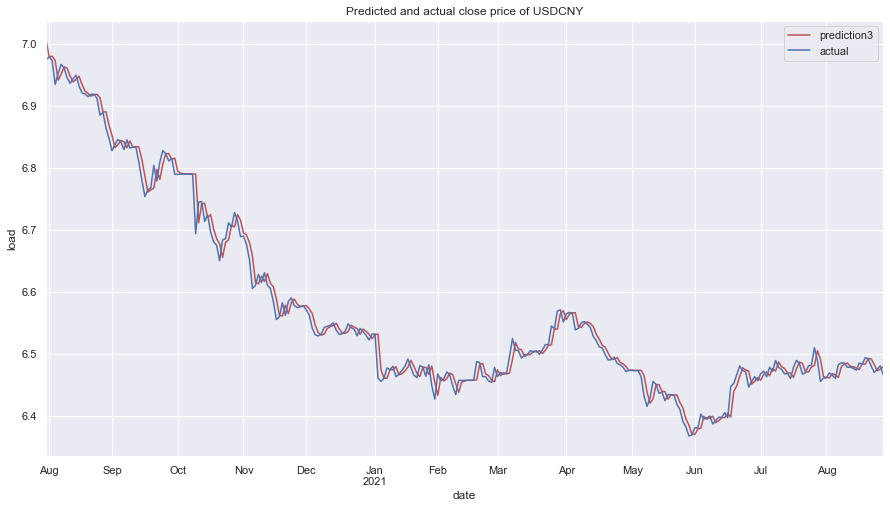

In [62]:
eval_df.plot(x='date', y=['prediction3', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.title('Predicted and actual close price of USDCNY')
plt.xlabel('date', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

# Random Forest model when K=3

In [63]:
from sklearn.ensemble import RandomForestRegressor

In [64]:
index_pre = er_price.index.get_loc(test_start) - K
true_valid_start = er_price.index[index_pre]
test_df = er_price[true_valid_start:].copy()
test_df['close'] = scaler.transform(test_df)
print(test_df.head(2).append(test_df.tail(2)))

               close
date                
2020-07-29  1.026497
2020-07-30  1.027133
2021-08-27  0.476206
2021-08-30  0.460625


In [65]:
#Random Forest
rfg = RandomForestRegressor()
rfg.fit(X_train, y_train)
rfg_pred = rfg.predict(X_test)

/var/folders/v3/450qq1rj1dg9h7f9glq8l6wh0000gn/T/ipykernel_65888/464134978.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfg.fit(X_train, y_train)


In [66]:
test_shifted = test_df.copy()
test_shifted['close_t+1'] = test_shifted['close'].shift(-1)
for t in range(0, K):
     test_shifted['close_t-{}'.format(t)] = test_shifted['close'].shift(t)
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted[y_data].values
X_test = test_shifted[X_data].values

In [67]:
predictions = rfg.predict(X_test)

In [68]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['date'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='date', value_name='prediction3', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction3', 'actual']] = scaler.inverse_transform(eval_df[['prediction3', 'actual']])
eval_df.head()

,date,h,prediction3,actual
0,2020-07-31,t+1,6.935351,6.9742
1,2020-08-03,t+1,6.935351,6.9794
2,2020-08-04,t+1,6.935351,6.9727
3,2020-08-05,t+1,6.935351,6.9346
4,2020-08-06,t+1,6.931241,6.9524


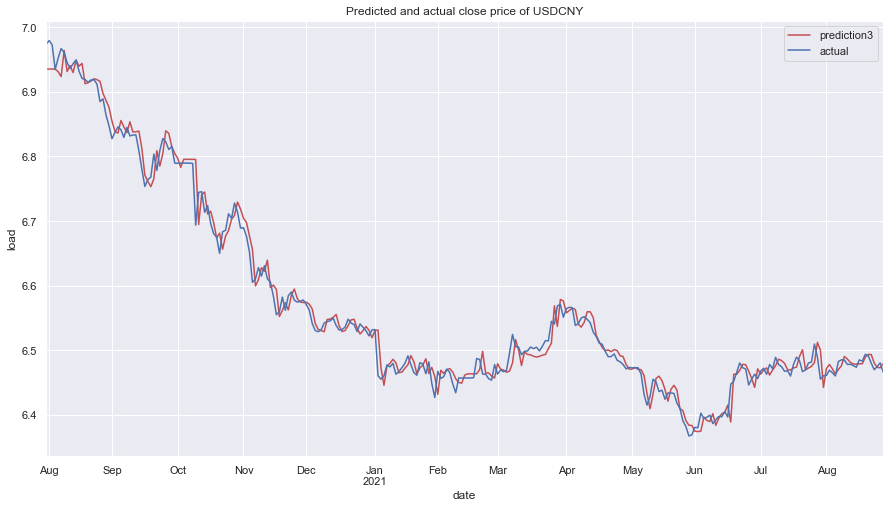

In [69]:
eval_df.plot(x='date', y=['prediction3', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.title('Predicted and actual close price of USDCNY')
plt.xlabel('date', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [70]:
print('Test MAE:',mean_absolute_error(y_test, rfg_pred))
print('Test MSE:',mean_squared_error(y_test, rfg_pred))
print("Test R2:",r2_score(y_test,rfg_pred))
mape_test = np.mean(np.abs((eval_df['prediction3'] - eval_df['actual']) / eval_df['actual'])) * 100
print('Testing MAPE is {:.2f}%'.format(mape_test))

Test MAE: 0.014165644218637707
Test MSE: 0.00037441943706123526
Test R2: 0.9861434797680282
Testing MAPE is 0.20%


# SVR model when K=5

In [71]:
K = 5
HORIZON = 1

In [72]:
train_er = er_price[:valid_start].copy()

               close
date                
2011-01-03  0.593959
2011-01-04  0.581664
2019-07-31  0.903445
2019-08-01  0.903233


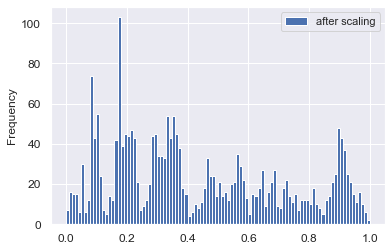

In [73]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_er['close'] = scaler.fit_transform(train_er)
print(train_er.head(2).append(train_er.tail(2)))
train_er.rename(columns={'close':'after scaling'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [74]:
train_shifted = train_er
train_shifted['close_t+1'] = train_er['close'].shift(-1)
train_shifted.head(2)

,close,close_t+1
date,,
2011-01-03,0.593959,0.581664
2011-01-04,0.581664,0.599682


In [75]:
for t in range(K):
    train_shifted['close_t-{}'.format(t)] = train_shifted['close'].shift(t)
train_shifted.head()

,close,close_t+1,close_t-0,close_t-1,close_t-2,close_t-3,close_t-4
date,,,,,,,
2011-01-03,0.593959,0.581664,0.593959,NaN,NaN,NaN,NaN
2011-01-04,0.581664,0.599682,0.581664,0.593959,NaN,NaN,NaN
2011-01-05,0.599682,0.579014,0.599682,0.581664,0.593959,NaN,NaN
2011-01-06,0.579014,0.620350,0.579014,0.599682,0.581664,0.593959,NaN
2011-01-07,0.620350,0.621410,0.620350,0.579014,0.599682,0.581664,0.593959


In [76]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head()

,close,close_t+1,close_t-0,close_t-1,close_t-2,close_t-3,close_t-4
date,,,,,,,
2011-01-07,0.620350,0.621410,0.620350,0.579014,0.599682,0.581664,0.593959
2011-01-10,0.621410,0.630419,0.621410,0.620350,0.579014,0.599682,0.581664
2011-01-11,0.630419,0.613461,0.630419,0.621410,0.620350,0.579014,0.599682
2011-01-12,0.613461,0.596714,0.613461,0.630419,0.621410,0.620350,0.579014
2011-01-13,0.596714,0.598304,0.596714,0.613461,0.630419,0.621410,0.620350


In [77]:
y_data = ['close_t+1']
X_data = ['close_t-{}'.format(idx) for idx in range(0, K)]

In [78]:
y_train = train_shifted[y_data].values
print(y_train.shape)
X_train = train_shifted[X_data].values
print(X_train.shape)

(2229, 1)
(2229, 5)


In [79]:
from sklearn.svm import SVR

from sklearn.metrics import r2_score

In [80]:
svr0 = SVR(kernel='rbf',gamma=0.005, C=100,epsilon=0.01)
svr0.fit(X_train, y_train)

/Users/yanzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100, epsilon=0.01, gamma=0.005)

In [81]:
index_pre = er_price.index.get_loc(valid_start) - K
true_valid_start = er_price.index[index_pre]

In [82]:
val_df = er_price[true_valid_start:test_start].copy()
val_df['close'] = scaler.transform(val_df)
print(val_df.head(2).append(val_df.tail(2)))

               close
date                
2019-07-25  0.890620
2019-07-26  0.890726
2020-07-31  1.034552
2020-08-03  0.999470


In [83]:
valid_shifted = val_df.copy()
valid_shifted['close_t+1'] = val_df['close'].shift(-1)
for t in range(K):
     valid_shifted['close_t-{}'.format(t)] = valid_shifted['close'].shift(t)
valid_shifted = valid_shifted.dropna(how='any')
y_valid = valid_shifted[y_data].values
X_valid = valid_shifted[X_data].values

In [84]:
predictions = svr0.predict(X_valid)
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = valid_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction5', var_name='h')
eval_df['actual'] = np.transpose(y_valid).ravel()
eval_df[['prediction5', 'actual']] = scaler.inverse_transform(eval_df[['prediction5', 'actual']])
eval_df.head()

,timestamp,h,prediction5,actual
0,2019-07-31,t+1,6.884458,6.8834
1,2019-08-01,t+1,6.884570,6.8978
2,2019-08-02,t+1,6.895025,6.9392
3,2019-08-05,t+1,6.930584,7.0497
4,2019-08-06,t+1,7.027280,7.0256


In [85]:
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [86]:
svr0_pred = svr0.predict(X_valid)
print('Valid MAE:',mean_absolute_error(y_valid, svr0_pred))
print('Valid MSE:',mean_squared_error(y_valid, svr0_pred))
print("Valid R2:",r2_score(y_valid, svr0_pred))
mape_test = np.mean(np.abs((eval_df['prediction5'] - eval_df['actual']) / eval_df['actual'])) * 100
print('Valid MAPE is {:.2f}%'.format(mape_test))

Valid MAE: 0.014191476815441232
Valid MSE: 0.0004452146055681995
Valid R2: 0.899923217986228
Valid MAPE is 0.19%


In [87]:
index_pre = er_price.index.get_loc(test_start) - K

In [88]:
true_valid_start = er_price.index[index_pre]
test_df = er_price[true_valid_start:].copy()
test_df['close'] = scaler.transform(test_df)
print(test_df.head(2).append(test_df.tail(2)))

               close
date                
2020-07-27  1.043879
2020-07-28  1.019608
2021-08-27  0.476206
2021-08-30  0.460625


In [89]:
test_shifted = test_df.copy()
test_shifted['close_t+1'] = test_shifted['close'].shift(-1)
for t in range(0, K):
     test_shifted['close_t-{}'.format(t)] = test_shifted['close'].shift(t)
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted[y_data].values
X_test = test_shifted[X_data].values

In [90]:
predictions = svr0.predict(X_test)

In [91]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['date'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='date', value_name='prediction5', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction5', 'actual']] = scaler.inverse_transform(eval_df[['prediction5', 'actual']])
eval_df.head()

,date,h,prediction5,actual
0,2020-07-31,t+1,7.004346,6.9742
1,2020-08-03,t+1,6.978320,6.9794
2,2020-08-04,t+1,6.979512,6.9727
3,2020-08-05,t+1,6.971133,6.9346
4,2020-08-06,t+1,6.940486,6.9524


In [92]:
svr0_pred = svr0.predict(X_test)
print('Test MAE:',mean_absolute_error(y_test, svr0_pred))
print('Test MSE:',mean_squared_error(y_test, svr0_pred))
print("Test R2:",r2_score(y_test, svr0_pred))
mape_test = np.mean(np.abs((eval_df['prediction5'] - eval_df['actual']) / eval_df['actual'])) * 100
print('Test MAPE is {:.2f}%'.format(mape_test))

Test MAE: 0.012103245100652743
Test MSE: 0.0002985404509785657
Test R2: 0.9889516104411803
Test MAPE is 0.17%


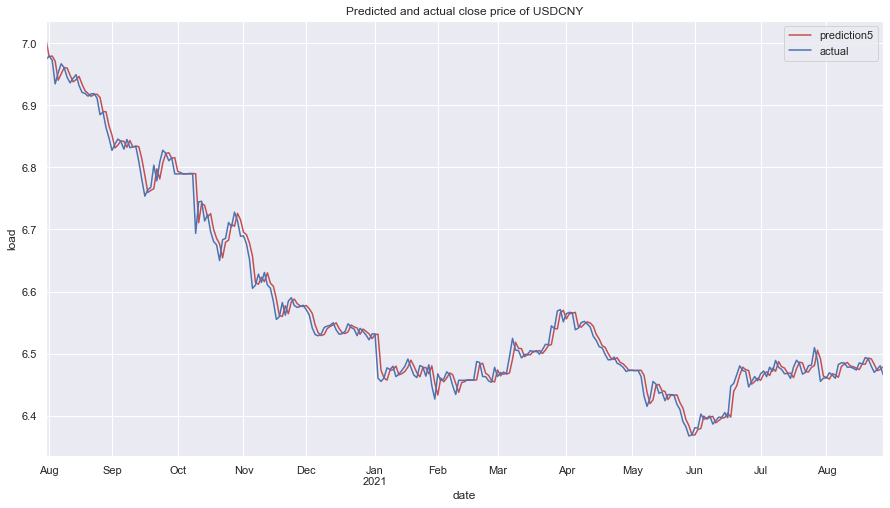

In [93]:
eval_df.plot(x='date', y=['prediction5', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.title('Predicted and actual close price of USDCNY')
plt.xlabel('date', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

# Random Forest model when K=5

In [94]:
from sklearn.ensemble import RandomForestRegressor

In [95]:
index_pre = er_price.index.get_loc(test_start) - K
true_valid_start = er_price.index[index_pre]
test_df = er_price[true_valid_start:].copy()
test_df['close'] = scaler.transform(test_df)
print(test_df.head(2).append(test_df.tail(2)))

               close
date                
2020-07-27  1.043879
2020-07-28  1.019608
2021-08-27  0.476206
2021-08-30  0.460625


In [96]:
#Random Forest
rfg = RandomForestRegressor()
rfg.fit(X_train, y_train)
rfg_pred = rfg.predict(X_test)

/var/folders/v3/450qq1rj1dg9h7f9glq8l6wh0000gn/T/ipykernel_65888/464134978.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfg.fit(X_train, y_train)


In [97]:
test_shifted = test_df.copy()
test_shifted['close_t+1'] = test_shifted['close'].shift(-1)
for t in range(0, K):
     test_shifted['close_t-{}'.format(t)] = test_shifted['close'].shift(t)
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted[y_data].values
X_test = test_shifted[X_data].values

In [98]:
predictions = rfg.predict(X_test)

In [99]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['date'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='date', value_name='prediction5', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction5', 'actual']] = scaler.inverse_transform(eval_df[['prediction5', 'actual']])
eval_df.head()

,date,h,prediction5,actual
0,2020-07-31,t+1,6.932756,6.9742
1,2020-08-03,t+1,6.932756,6.9794
2,2020-08-04,t+1,6.932756,6.9727
3,2020-08-05,t+1,6.932756,6.9346
4,2020-08-06,t+1,6.934704,6.9524


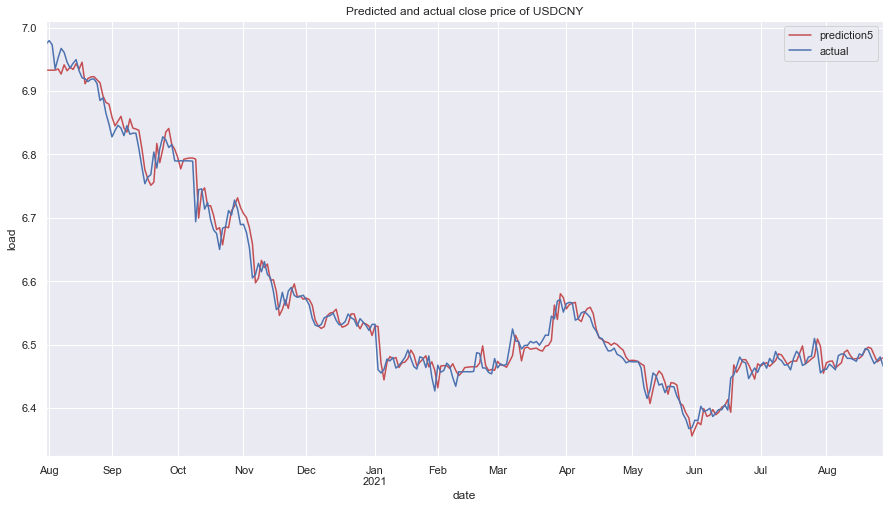

In [100]:
eval_df.plot(x='date', y=['prediction5', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.title('Predicted and actual close price of USDCNY')
plt.xlabel('date', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [101]:
print('Test MAE:',mean_absolute_error(y_test, rfg_pred))
print('Test MSE:',mean_squared_error(y_test, rfg_pred))
print("Test R2:",r2_score(y_test,rfg_pred))
mape_test = np.mean(np.abs((eval_df['prediction5'] - eval_df['actual']) / eval_df['actual'])) * 100
print('Testing MAPE is {:.2f}%'.format(mape_test))

Test MAE: 0.01408513805830108
Test MSE: 0.0003738927200208544
Test R2: 0.9861629725202844
Testing MAPE is 0.20%


# SVR model when K=7

In [102]:
K = 7
HORIZON = 1

In [103]:
train_er = er_price[:valid_start].copy()

               close
date                
2011-01-03  0.593959
2011-01-04  0.581664
2019-07-31  0.903445
2019-08-01  0.903233


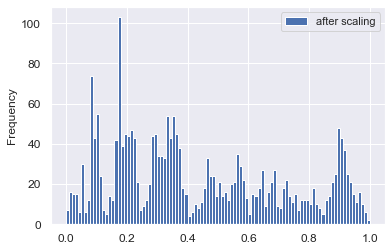

In [104]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_er['close'] = scaler.fit_transform(train_er)
print(train_er.head(2).append(train_er.tail(2)))
train_er.rename(columns={'close':'after scaling'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [105]:
train_shifted = train_er
train_shifted['close_t+1'] = train_er['close'].shift(-1)
train_shifted.head(2)

,close,close_t+1
date,,
2011-01-03,0.593959,0.581664
2011-01-04,0.581664,0.599682


In [106]:
for t in range(K):
    train_shifted['close_t-{}'.format(t)] = train_shifted['close'].shift(t)
train_shifted.head()

,close,close_t+1,close_t-0,close_t-1,close_t-2,close_t-3,close_t-4,close_t-5,close_t-6
date,,,,,,,,,
2011-01-03,0.593959,0.581664,0.593959,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,0.581664,0.599682,0.581664,0.593959,NaN,NaN,NaN,NaN,NaN
2011-01-05,0.599682,0.579014,0.599682,0.581664,0.593959,NaN,NaN,NaN,NaN
2011-01-06,0.579014,0.620350,0.579014,0.599682,0.581664,0.593959,NaN,NaN,NaN
2011-01-07,0.620350,0.621410,0.620350,0.579014,0.599682,0.581664,0.593959,NaN,NaN


In [107]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head()

,close,close_t+1,close_t-0,close_t-1,close_t-2,close_t-3,close_t-4,close_t-5,close_t-6
date,,,,,,,,,
2011-01-11,0.630419,0.613461,0.630419,0.621410,0.620350,0.579014,0.599682,0.581664,0.593959
2011-01-12,0.613461,0.596714,0.613461,0.630419,0.621410,0.620350,0.579014,0.599682,0.581664
2011-01-13,0.596714,0.598304,0.596714,0.613461,0.630419,0.621410,0.620350,0.579014,0.599682
2011-01-14,0.598304,0.580816,0.598304,0.596714,0.613461,0.630419,0.621410,0.620350,0.579014
2011-01-17,0.580816,0.585162,0.580816,0.598304,0.596714,0.613461,0.630419,0.621410,0.620350


In [108]:
y_data = ['close_t+1']
X_data = ['close_t-{}'.format(idx) for idx in range(0, K)]

In [109]:
y_train = train_shifted[y_data].values
print(y_train.shape)
X_train = train_shifted[X_data].values
print(X_train.shape)

(2227, 1)
(2227, 7)


In [110]:
from sklearn.svm import SVR

from sklearn.metrics import r2_score

In [111]:
svr0 = SVR(kernel='rbf',gamma=0.005, C=100,epsilon=0.01)
svr0.fit(X_train, y_train)

/Users/yanzi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100, epsilon=0.01, gamma=0.005)

In [112]:
index_pre = er_price.index.get_loc(valid_start) - K
true_valid_start = er_price.index[index_pre]

In [113]:
val_df = er_price[true_valid_start:test_start].copy()
val_df['close'] = scaler.transform(val_df)
print(val_df.head(2).append(val_df.tail(2)))

               close
date                
2019-07-23  0.899735
2019-07-24  0.897827
2020-07-31  1.034552
2020-08-03  0.999470


In [114]:
valid_shifted = val_df.copy()
valid_shifted['close_t+1'] = val_df['close'].shift(-1)
for t in range(K):
     valid_shifted['close_t-{}'.format(t)] = valid_shifted['close'].shift(t)
valid_shifted = valid_shifted.dropna(how='any')
y_valid = valid_shifted[y_data].values
X_valid = valid_shifted[X_data].values

In [115]:
predictions = svr0.predict(X_valid)
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = valid_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction7', var_name='h')
eval_df['actual'] = np.transpose(y_valid).ravel()
eval_df[['prediction7', 'actual']] = scaler.inverse_transform(eval_df[['prediction7', 'actual']])
eval_df.head()

,timestamp,h,prediction7,actual
0,2019-07-31,t+1,6.883974,6.8834
1,2019-08-01,t+1,6.884160,6.8978
2,2019-08-02,t+1,6.895043,6.9392
3,2019-08-05,t+1,6.931131,7.0497
4,2019-08-06,t+1,7.028145,7.0256


In [116]:
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [117]:
svr0_pred = svr0.predict(X_valid)
print('Valid MAE:',mean_absolute_error(y_valid, svr0_pred))
print('Valid MSE:',mean_squared_error(y_valid, svr0_pred))
print("Valid R2:",r2_score(y_valid, svr0_pred))
mape_test = np.mean(np.abs((eval_df['prediction7'] - eval_df['actual']) / eval_df['actual'])) * 100
print('Valid MAPE is {:.2f}%'.format(mape_test))

Valid MAE: 0.014453722002763335
Valid MSE: 0.0004498561643197331
Valid R2: 0.898879873366416
Valid MAPE is 0.19%


In [118]:
index_pre = er_price.index.get_loc(test_start) - K

In [119]:
true_valid_start = er_price.index[index_pre]
test_df = er_price[true_valid_start:].copy()
test_df['close'] = scaler.transform(test_df)
print(test_df.head(2).append(test_df.tail(2)))

               close
date                
2020-07-23  1.025437
2020-07-24  1.030101
2021-08-27  0.476206
2021-08-30  0.460625


In [120]:
test_shifted = test_df.copy()
test_shifted['close_t+1'] = test_shifted['close'].shift(-1)
for t in range(0, K):
     test_shifted['close_t-{}'.format(t)] = test_shifted['close'].shift(t)
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted[y_data].values
X_test = test_shifted[X_data].values

In [121]:
predictions = svr0.predict(X_test)

In [122]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['date'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='date', value_name='prediction7', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction7', 'actual']] = scaler.inverse_transform(eval_df[['prediction7', 'actual']])
eval_df.head()

,date,h,prediction7,actual
0,2020-07-31,t+1,7.003593,6.9742
1,2020-08-03,t+1,6.976596,6.9794
2,2020-08-04,t+1,6.978217,6.9727
3,2020-08-05,t+1,6.970192,6.9346
4,2020-08-06,t+1,6.939266,6.9524


In [123]:
svr0_pred = svr0.predict(X_test)
print('Test MAE:',mean_absolute_error(y_test, svr0_pred))
print('Test MSE:',mean_squared_error(y_test, svr0_pred))
print("Test R2:",r2_score(y_test, svr0_pred))
mape_test = np.mean(np.abs((eval_df['prediction7'] - eval_df['actual']) / eval_df['actual'])) * 100
print('Test MAPE is {:.2f}%'.format(mape_test))

Test MAE: 0.012078681415777798
Test MSE: 0.00029808945623237157
Test R2: 0.9889683008616195
Test MAPE is 0.17%


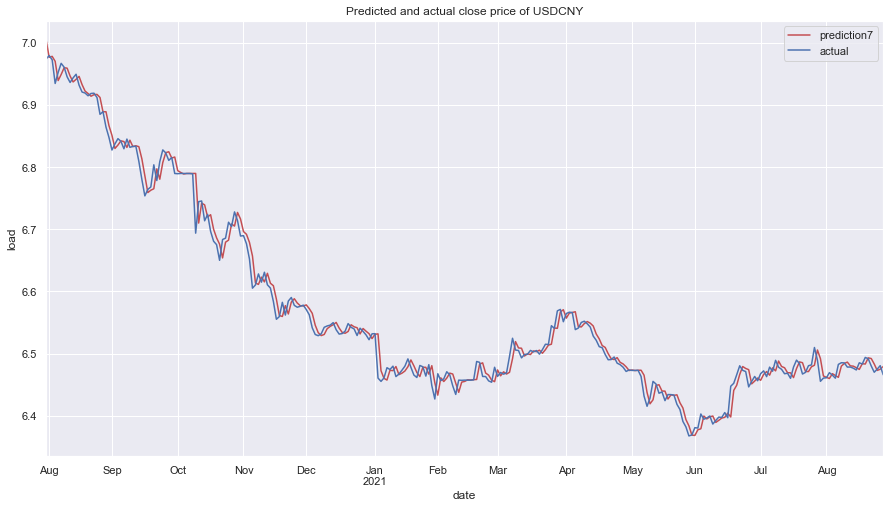

In [124]:
eval_df.plot(x='date', y=['prediction7', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.title('Predicted and actual close price of USDCNY')
plt.xlabel('date', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

# Random Forest model when K=7

In [125]:
from sklearn.ensemble import RandomForestRegressor

In [126]:
index_pre = er_price.index.get_loc(test_start) - K
true_valid_start = er_price.index[index_pre]
test_df = er_price[true_valid_start:].copy()
test_df['close'] = scaler.transform(test_df)
print(test_df.head(2).append(test_df.tail(2)))

               close
date                
2020-07-23  1.025437
2020-07-24  1.030101
2021-08-27  0.476206
2021-08-30  0.460625


In [127]:
rfg = RandomForestRegressor()
rfg.fit(X_train, y_train)
rfg_pred = rfg.predict(X_test)

/var/folders/v3/450qq1rj1dg9h7f9glq8l6wh0000gn/T/ipykernel_65888/2676831714.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfg.fit(X_train, y_train)


In [128]:
test_shifted = test_df.copy()
test_shifted['close_t+1'] = test_shifted['close'].shift(-1)
for t in range(0, K):
     test_shifted['close_t-{}'.format(t)] = test_shifted['close'].shift(t)
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted[y_data].values
X_test = test_shifted[X_data].values

In [129]:
predictions = rfg.predict(X_test)

In [130]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['date'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='date', value_name='prediction7', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction7', 'actual']] = scaler.inverse_transform(eval_df[['prediction7', 'actual']])
eval_df.head()

,date,h,prediction7,actual
0,2020-07-31,t+1,6.923089,6.9742
1,2020-08-03,t+1,6.923089,6.9794
2,2020-08-04,t+1,6.923089,6.9727
3,2020-08-05,t+1,6.923089,6.9346
4,2020-08-06,t+1,6.925219,6.9524


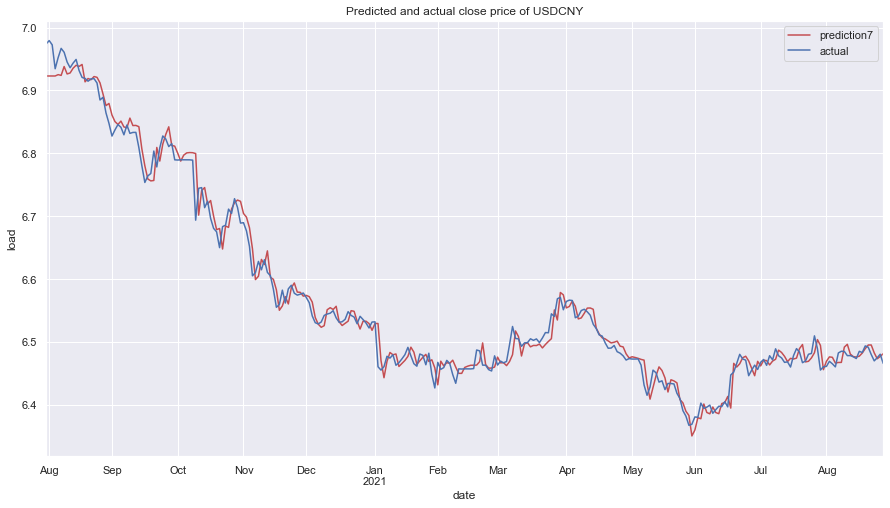

In [131]:
eval_df.plot(x='date', y=['prediction7', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.title('Predicted and actual close price of USDCNY')
plt.xlabel('date', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [132]:
print('Test MAE:',mean_absolute_error(y_test, rfg_pred))
print('Test MSE:',mean_squared_error(y_test, rfg_pred))
print("Test R2:",r2_score(y_test,rfg_pred))
mape_test = np.mean(np.abs((eval_df['prediction7'] - eval_df['actual']) / eval_df['actual'])) * 100
print('Testing MAPE is {:.2f}%'.format(mape_test))

Test MAE: 0.0145763653542594
Test MSE: 0.00039743316529723655
Test R2: 0.985291787362799
Testing MAPE is 0.21%
